In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import preproc
from join_data import join_y
import feature_eng
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

## Reading in data and preproc

In [22]:
df = pd.read_json('laptops.json')
df = join_y(df, 'laptops_sales.csv')
df = preproc.clean_cols(df)
df = preproc.fill_empty_lists(df)
df = preproc.preprocess_reviews(df)
df = feature_eng.generate_features(df)
df = feature_eng.do_PCA(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
from sklearn.metrics import silhouette_score
def evaluate_clusters(
    X,
    predicted_y,
    binned_y,
    qbinned_y,
 
):
    """Evaluates clustering results, uses silouette and rand if specified. Cannot be used with DBSCAN"""
    s_score = silhouette_score(X, predicted_y)
    f, axes = plt.subplots(2,1, figsize=(10,15))
    sns.kdeplot(predicted_y, binned_y.astype(int), shade=True, ax=axes[0])
    axes[0].set_title('Cluster labels with spacially binned sales')
    sns.kdeplot(predicted_y, qbinned_y.astype(int), shade=True, ax=axes[1])
    axes[1].set_title('Cluster labels with quantile binned sales')
    print(f"Silhouette score: {s_score}")

In [24]:
df.head(1)

,index,product_name,price,urls,remotekey,shelf_order,item_category,no_reviews,recommendation_percent,review_date,review_rating,review_text,review_title,summary_star_rating,code,TOTAL_SALES,text_preproc,text_preproc2,neg_reviews,pos_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol,index,c1,c2
0,0,hp 14in ryzen 3 4gb 128gb fhd laptop black,399.99,https://www.argos.co.uk/product/9200856?clickP...,9200856,2,[Includes Microsoft 365 Personal and 1TB OneDr...,17,100,"[30 July 2021, 30 July 2021, 21 July 2021, 8 J...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",[Easy to set up and navigate. Nice and slim an...,"[Love my new HP laptop, Easy to use, Great lap...",4.9,3313337993733739104503754749411541515033011334...,1810,"[[easy, to, set, up, and, navigate, nice, and,...","[[easy, set, navigate, nice, slim, light, carr...",0,17,23.528824,0.17,1.0,0.0,0,-0.120458,-1.31103


# Distributions

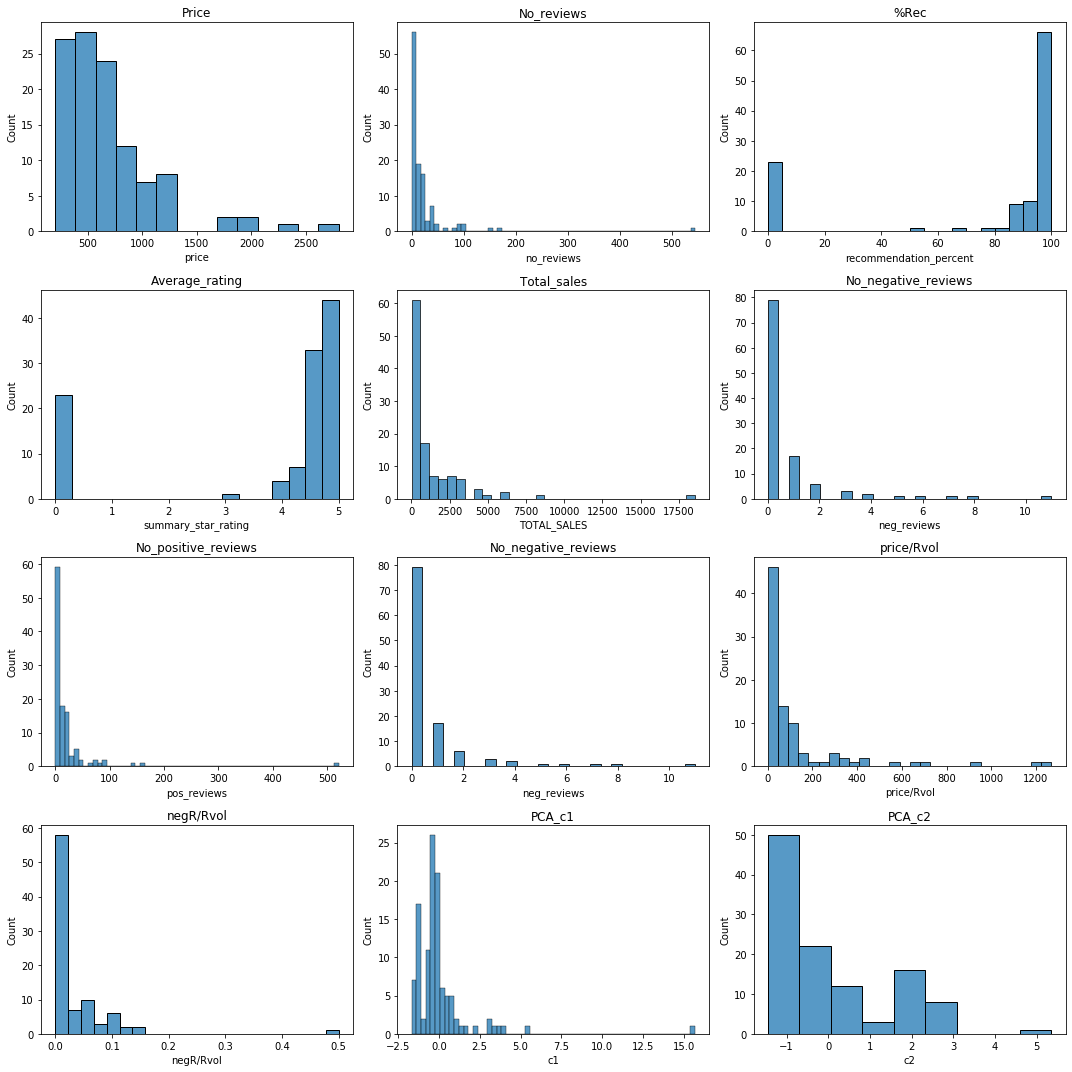

In [25]:
f, axes = plt.subplots(4,3, figsize=(15,15))
sns.histplot(df['price'].dropna(), ax=axes[0,0])
axes[0,0].set_title('Price')
sns.histplot(df['no_reviews'].dropna(), ax=axes[0,1])
axes[0,1].set_title('No_reviews')
sns.histplot(df['recommendation_percent'].dropna(), ax=axes[0,2])
axes[0,2].set_title('%Rec')
sns.histplot(df['summary_star_rating'].dropna(), ax=axes[1,0])
axes[1,0].set_title('Average_rating')
sns.histplot(df['TOTAL_SALES'].dropna(), ax=axes[1,1])
axes[1,1].set_title('Total_sales')
sns.histplot(df['neg_reviews'].dropna(), ax=axes[1,2])
axes[1,2].set_title('No_negative_reviews')
sns.histplot(df['neg_reviews'].dropna(), ax=axes[2,1])
axes[2,1].set_title('No_negative_reviews')
sns.histplot(df['pos_reviews'].dropna(), ax=axes[2,0])
axes[2,0].set_title('No_positive_reviews')
sns.histplot(df['price/Rvol'].dropna(), ax=axes[2,2])
axes[2,2].set_title('price/Rvol')
sns.histplot(df['negR/Rvol'].dropna(), ax=axes[3,0])
axes[3,0].set_title('negR/Rvol')
sns.histplot(df['c1'].dropna(), ax=axes[3,1])
axes[3,1].set_title('PCA_c1')
sns.histplot(df['c2'].dropna(), ax=axes[3,2])
axes[3,2].set_title('PCA_c2')

plt.tight_layout()

## Scaling

In [30]:
# 0 mean variance scaling, keeps NANS
sdf = df.select_dtypes(include=['float','int64'])
sdf['price/Rvol'] = sdf['price/Rvol'].replace(np.inf, sdf['price/Rvol'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])

## Kmeans - PCA

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X=sdf[['c1','c2']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


(-1, 4)

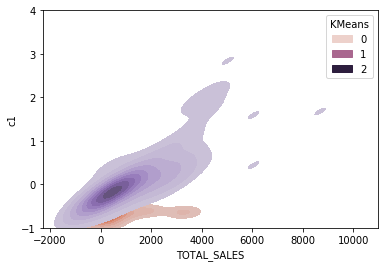

In [33]:
sns.kdeplot(x=sdf['TOTAL_SALES'].astype(int),y= sdf['c1'], hue=sdf['KMeans'] ,shade=True)
plt.ylim([-1,4])

Silhouette score: 0.676102929588743


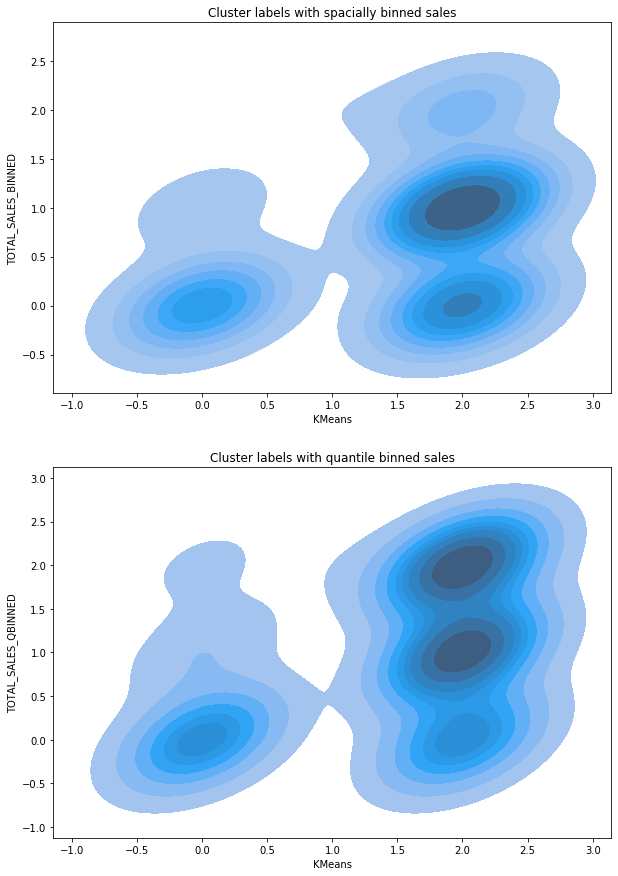

In [34]:
evaluate_clusters(X, sdf['KMeans'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

## KMeans - PCA with outliers removal

In [ ]:
df.columns

Text(0.5, 1.0, 'Z-scores of primary comp')

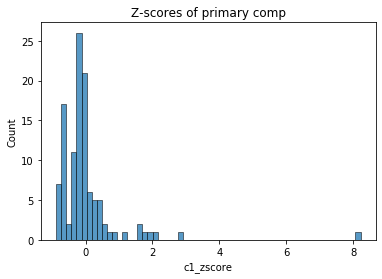

In [36]:
sdf = df.select_dtypes(include=['float','int64'])
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])
sdf['c1_zscore'] = (sdf['c1']-sdf['c1'].mean())/sdf['c1'].std()
X = sdf[['c1','c2']]
sns.histplot(sdf['c1_zscore'])
plt.title('Z-scores of primary comp')

Text(0.5, 1.0, 'Z-scores of primary comp')

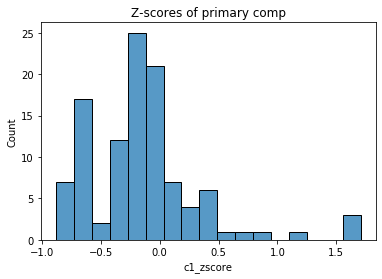

In [37]:
sdf = sdf.loc[sdf['c1_zscore'] <=2]
sns.histplot(sdf['c1_zscore'])
plt.title('Z-scores of primary comp')

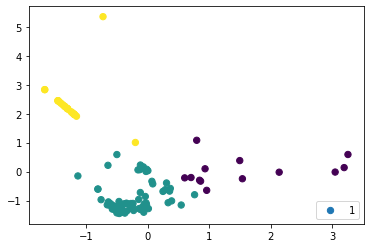

In [38]:
X=sdf[['c1','c2']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)
plt.scatter(X['c1'], X['c2'], c=y_km, s=40, cmap='viridis')
plt.legend(y_km, loc=4)


Silhouette score: 0.6332354813229732


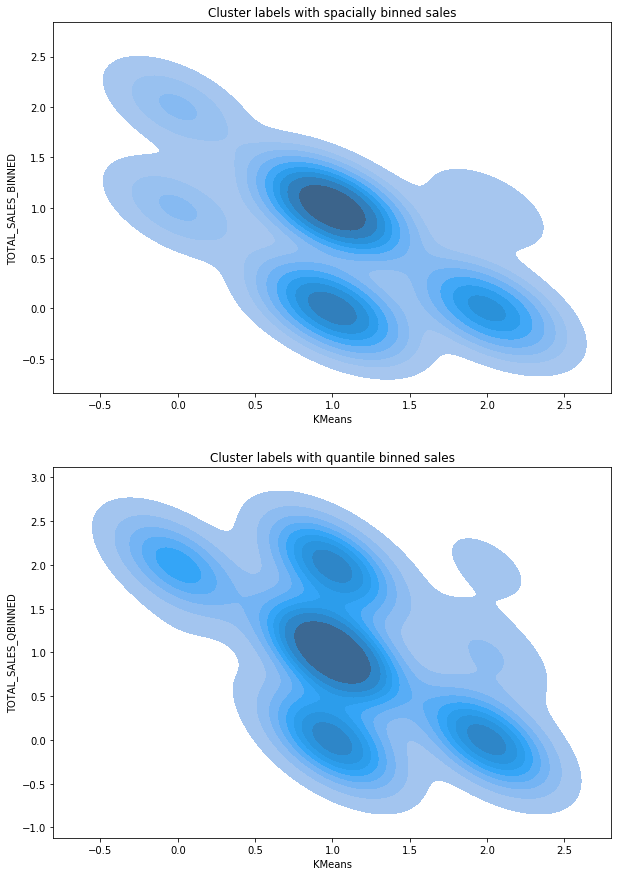

In [39]:
evaluate_clusters(X, sdf['KMeans'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

(-1, 2)

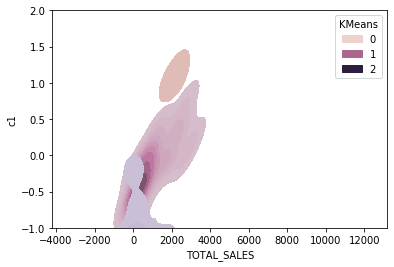

In [40]:
sns.kdeplot(x=sdf['TOTAL_SALES'].astype(int),y= sdf['c1'], hue=sdf['KMeans'] ,shade=True)
plt.ylim([-1,2])

## KMeans - Top 3 features

In [43]:
sdf=df[['no_reviews','Rvol/%rec','pos_reviews']]
sdf['Rvol/%rec'] = sdf['Rvol/%rec'].replace(np.nan, sdf['Rvol/%rec'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])
X = sdf[['no_reviews','Rvol/%rec','pos_reviews']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


Silhouette score: 0.8193670620856404


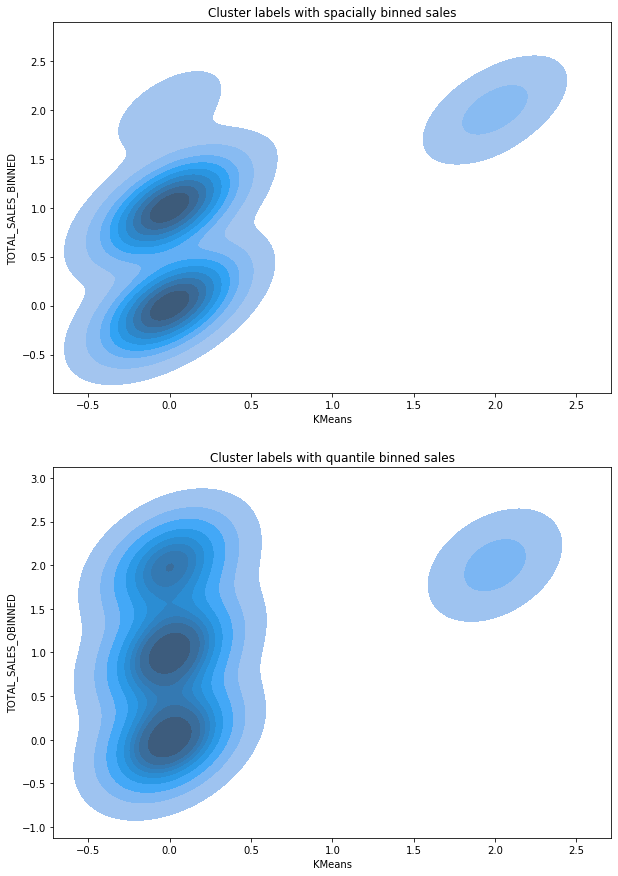

In [44]:
evaluate_clusters(X, sdf['KMeans'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])


In [48]:
sdf.loc[sdf.KMeans==2]

,no_reviews,Rvol/%rec,pos_reviews,TOTAL_SALES,TOTAL_SALES_BINNED,TOTAL_SALES_QBINNED,KMeans
4,0.957636,0.941663,0.918956,3278,2,2,2
8,2.576912,2.577856,2.582250,5038,2,2,2
20,1.271045,1.264596,1.229682,8686,2,2,2
93,1.166575,1.228715,1.065180,4311,2,2,2
97,1.358102,1.335226,1.321071,6067,2,2,2
98,2.298327,2.293826,2.289802,4158,2,2,2
108,1.201398,1.411580,1.010346,4126,2,2,2
110,0.783521,0.700642,0.827567,3055,1,2,2


**Could be onto something here**

In [49]:
sdf.loc[sdf.TOTAL_SALES_BINNED==2]

,no_reviews,Rvol/%rec,pos_reviews,TOTAL_SALES,TOTAL_SALES_BINNED,TOTAL_SALES_QBINNED,KMeans
3,0.052235,-0.000971,0.023337,3453,2,2,0
4,0.957636,0.941663,0.918956,3278,2,2,2
5,-0.400466,-0.221612,-0.397056,3278,2,2,0
7,0.174116,0.134332,0.151283,6051,2,2,0
8,2.576912,2.577856,2.582250,5038,2,2,2
19,9.071427,9.098706,9.125755,18554,2,2,1
20,1.271045,1.264596,1.229682,8686,2,2,2
93,1.166575,1.228715,1.065180,4311,2,2,2
97,1.358102,1.335226,1.321071,6067,2,2,2
98,2.298327,2.293826,2.289802,4158,2,2,2


**7/11 are labelled as 2, however the most sales isn't in fucking 2**

In [52]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [53]:


cluster_report(X, y_km, )

,class_name,instance_count,rule_list
0,0,103,[1.0] (pos_reviews <= -0.20513731241226196)[0.82] (pos_reviews > -0.20513731241226196)
2,1,1,NaN
1,2,8,NaN


## Kmeans - top 3 features without outliers

In [ ]:
sdf=df[['no_reviews','Rvol/%rec','pos_reviews']]
sdf['Rvol/%rec'] = sdf['Rvol/%rec'].replace(np.nan, sdf['Rvol/%rec'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']

sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])
X = sdf[['no_reviews','Rvol/%rec','pos_reviews']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


In [ ]:
"""NEXT TO DO 
-TRY THE OTHER VERSION OF CLUSTER REPORT WHICH CAN BE FOUND ON THE ARTICLE
-TRY REMOVING THE OUTLIER AND RECLUSTERING (BOTH ON PCA AND NON/PCA)
-CREATE A NEW VARIABLE USING THE TEXT DATA AND THEN TEST AGAIN, DO FEATURE IMOPORTANCE AGAIN WITH OLS
-TRY AGGLOROATIVE CLUSTEIRNG AND DBSCAN.
"""

In [ ]:
# dbscan clusters are quite nice, all high sales are -1 and all lowest sales are 1. 
# there are many points which lie in the middle as 0s. Perhaps multiple clustering could be combined

# birch is fucking good, the highest seller has a point of its own (3) and all the next top sellers have a point of their own
# most next top sellers are all 2s with a small bit of leakage
# there are few 1s, 0s dominate the lowest sellers but also leak into the top
# PROMISING